In this notebook, we show how to compute the effect of charge dephasing, as shown in Fig. 13 of the manuscript.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport resources

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, hbar, k
import qutip as qt

from resources import Hamiltonian1DVirtual, Simulation, solve_resonance, compute_map, num

k_b = k / e * 10 ** 6  # Boltzmann constant [ueV / K]

cmap = plt.get_cmap('gist_heat_r')

In [3]:
N = 4
n_particles = [0, 1]

tau = [3, 5, 2]
U = np.array([1500, 1650, 1220, 1800])  # ueV
V1 = 1000
Vs = np.array([0, V1, V1 / 2, V1 / 3])

gamma_charge = 1  # ueV
c_ops = [np.sqrt(gamma_charge) * num(N, i)[:] for i in range(N)]  # Charge dephasing operators

alpha = np.zeros((N, N))  # ueV / mV
alpha[:, 0] = [-85, -36, -12, -7]
alpha[:, 3] = [-7, -12, -32, -81]

V_i = [0, 0, 0, 0]  # V
eps_0 = np.array([0., 7, -5, 0.])  # ueV

T = 0.1  # K
beta = 1 / (k_b * T) if T != 0 else np.inf  # ueV^-1

Deltas = np.array([0.15, 0.2, 0.1, 0.14])
T1 = 1e3  # Relaxation (ns)
T2 = 10  # Decoherence (ns)

mu0 = 0
Delta_mu = 75
mus = np.array([0.] * N)
mus[0] = mu0 + Delta_mu / 2
mus[-1] = mu0 - Delta_mu / 2

Gammas = np.array([0.] * N)
Gammas[0] = 0.28  # uev
Gammas[-1] = 0.21
gamma = Gammas[-1]

intensity_contribution = np.array([0] * N)
intensity_contribution[-1] = 1

gamma = Gammas[-1]
gamma_J = gamma * 1e-6 * e  # J
current_change = gamma_J * e / hbar * 1e12  # pA

hamiltonian = Hamiltonian1DVirtual(N=N, tau=tau, U=U, Vs=Vs, Gammas=Gammas, mus=mus, beta=beta, n_particles=n_particles,
                                   hbar=1, T2=T2, T1=T1, intensity_contribution=intensity_contribution, Deltas=Deltas,
                                   alpha=alpha, V_i=V_i, eps_0=eps_0)

simulation = Simulation(hamiltonian)

c_ops = [qt.Qobj(hamiltonian.get_operator(c_op)) for c_op in c_ops]

In [4]:
n_V = 100  # Increase this number for finer resolution

v_1_run = np.linspace(-1, 1, n_V) * 1
v_4_run = np.linspace(-1, 1, n_V) * 1

V_1, V_4 = [x.flatten() for x in np.meshgrid(v_1_run, v_4_run)]

n_total = len(V_1)
V_s = [[V_1[i], 0., 0., V_4[i]] for i in range(n_total)]

In [5]:
intensity, *_ = compute_map(simulation, V_s, 'V_i', v_1_run, v_4_run, n_workers=-1,
                            ss_kw={'method': 'direct', 'solver': 'spsolve'}, c_ops=c_ops)

intensity *= current_change

compute_current_ss: [['V_i']]:   0%|          | 0/10000 [00:00<?, ?it/s]

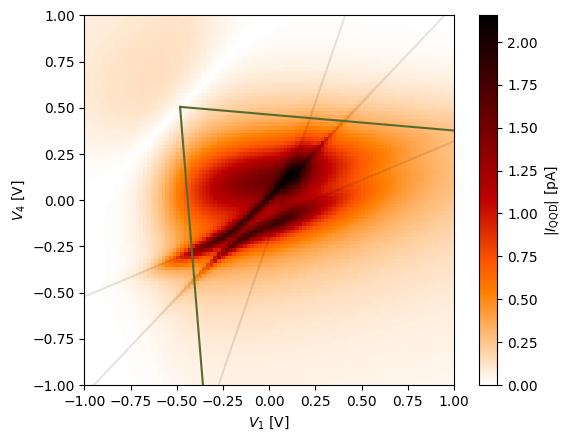

In [6]:
fig, ax = plt.subplots()

im = ax.imshow(np.abs(intensity), origin='lower', aspect='equal', vmin=0,
               extent=[min(v_1_run), max(v_1_run), min(v_4_run), max(v_4_run)], cmap=cmap)

ax.set_xlabel(r'$V_1$ [V]')
ax.set_ylabel(r'$V_4$ [V]')
cbar = plt.colorbar(im, label=r'$|I_\mathrm{QQD}|$ [pA]')

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

resonances = [['1000', '0001'], ['0100', '0001'], ['1000', '0010']]
for resonance in resonances:
    ax.plot([min(v_1_run), max(v_1_run)], solve_resonance(hamiltonian, resonance,
                                                          [min(v_1_run), max(v_1_run)]),
            color='k', alpha=0.1, ls='-')

v_1_stop = (alpha[3, 3] * mus[0] - alpha[0, 3] * mus[-1]) / (- alpha[0, 3] * alpha[3, 0] + alpha[0, 0] * alpha[3, 3])
v_1_plot = np.array([v_1_stop, np.max(v_1_run)])

ax.plot(v_1_plot, (-v_1_plot * alpha[0, 0] + mus[0]) / alpha[0, 3], color='darkolivegreen')  # (0,0,0,0) ---> (1,0,0,0)
ax.plot(v_1_plot, (-v_1_plot * alpha[3, 0] + mus[-1]) / alpha[3, 3], color='darkolivegreen')  # (0,0,0,0) ---> (0,0,0,1)

ax.set_xlim(*x_lim)
ax.set_ylim(*y_lim);